<a href="https://colab.research.google.com/github/yuliastoliaruk/Computer_Vision_NaUKMA/blob/main/intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.utils import make_grid
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Preparation (Practice 1)

### Data Augmentation

In [ ]:
transform_train_data = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
data_path = "/content/drive/MyDrive/Intel_Image_Classification/data"

data_train = torchvision.datasets.ImageFolder(root=f"{data_path}/seg_train", transform=transform_train_data)
data_test = torchvision.datasets.ImageFolder(root=f"{data_path}/seg_test", transform=transform_test_data)

In [ ]:
print("Classes:", data_train.classes)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Split into training and validation sets.

In [ ]:
def images_per_class(data, dataset=None):
    if dataset is None:
        labels = data.targets
    else:
        labels = [data.targets[i] for i in dataset.indices]

    class_counts = Counter(labels)
    class_names = data.classes

    print('Number of images in each class:')
    for class_id, count in class_counts.items():
        print(f"{class_names[class_id]}: {count} images")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, [class_counts[i] for i in range(len(class_names))], color='purple')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    return plt

Number of images in each class:
buildings: 437 images
forest: 474 images
glacier: 553 images
mountain: 525 images
sea: 510 images
street: 501 images


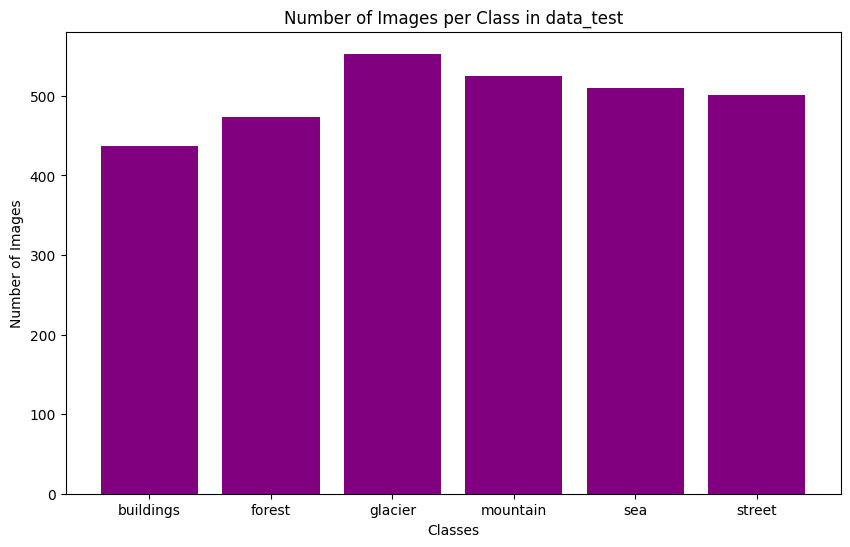

In [ ]:
plt = images_per_class(data_test)
plt.title('Number of Images per Class in data_test')
plt.show()

Number of images in each class:
buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


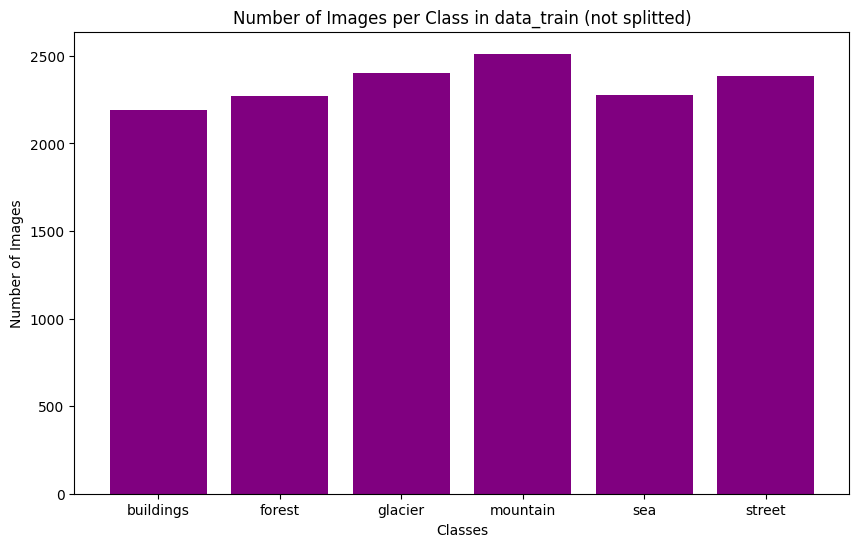

In [ ]:
plt = images_per_class(data_train)
plt.title('Number of Images per Class in data_train (not splitted)')
plt.show()

As we can see from the bar plot, the training dataset is imbalanced. To balance the data, I will take 1900 images from each class for `train_ds`, and the rest will go to `val_ds`

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

labels = np.array(data_train.targets)
num_classes = len(set(labels))
samples_per_class = 1900

class_indices = defaultdict(list)

for idx, label in enumerate(labels):
    class_indices[label].append(idx)

train_indices = []
val_indices = []

for class_id, indices in class_indices.items():
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_class_indices = indices[:samples_per_class]
    val_class_indices = indices[samples_per_class:]

    train_indices.extend(train_class_indices)
    val_indices.extend(val_class_indices)

train_ds = Subset(data_train, train_indices)
val_ds = Subset(data_train, val_indices)

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Number of images in each class:
buildings: 1900 images
forest: 1900 images
glacier: 1900 images
mountain: 1900 images
sea: 1900 images
street: 1900 images


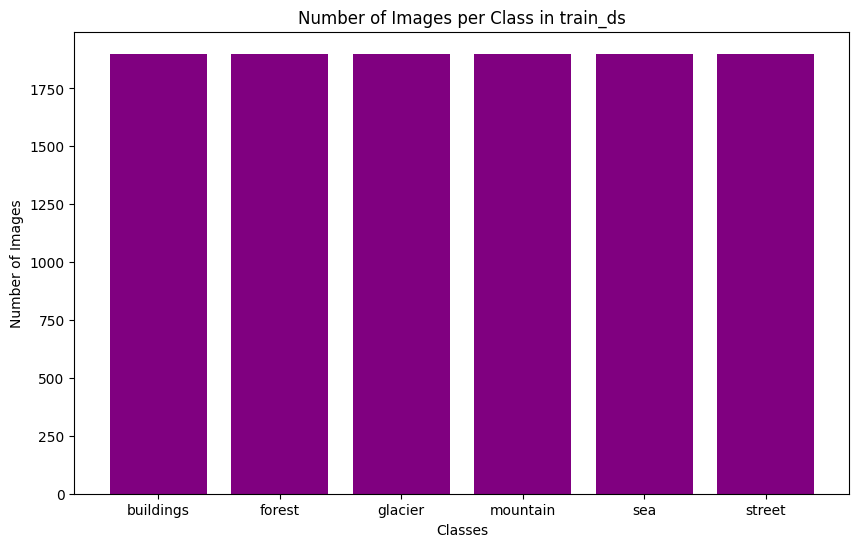

In [ ]:
plt = images_per_class(data_train, train_ds)
plt.title('Number of Images per Class in train_ds')
plt.show()

Number of images in each class:
buildings: 291 images
forest: 371 images
glacier: 504 images
mountain: 612 images
sea: 374 images
street: 482 images


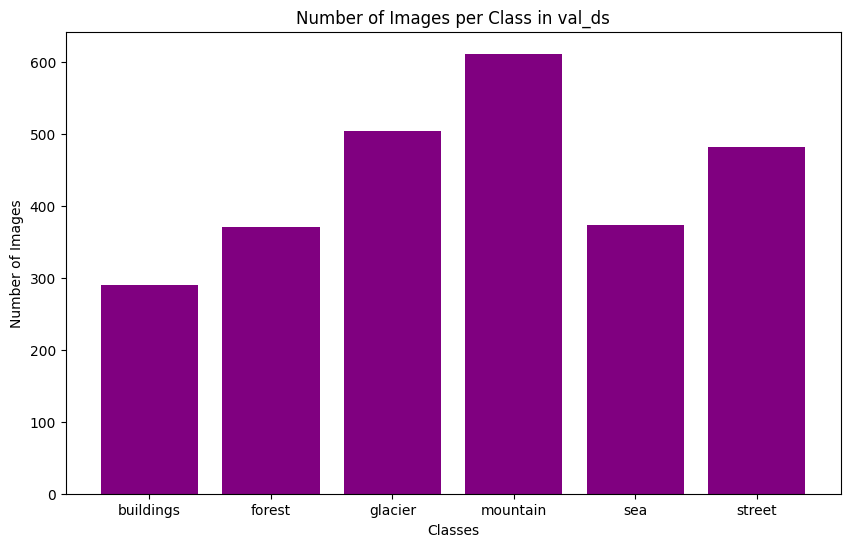

In [ ]:
plt = images_per_class(data_train, val_ds)
plt.title('Number of Images per Class in val_ds')
plt.show()

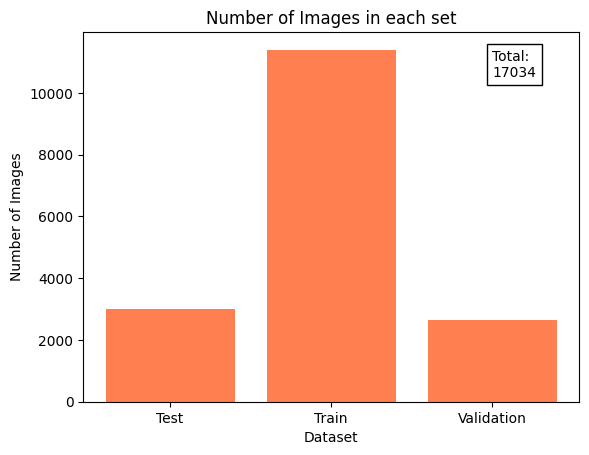

In [ ]:
plt.bar(['Test', 'Train', 'Validation'], [len(data_test), len(train_ds), len(val_ds)], color='coral')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in each set')
plt.text(2, len(data_train)*0.75, f"Total:\n{len(data_test) + len(data_train)}", bbox=dict(facecolor="white", edgecolor="black"))
plt.show()

### Denormalization

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy() if isinstance(img, torch.Tensor) else img
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

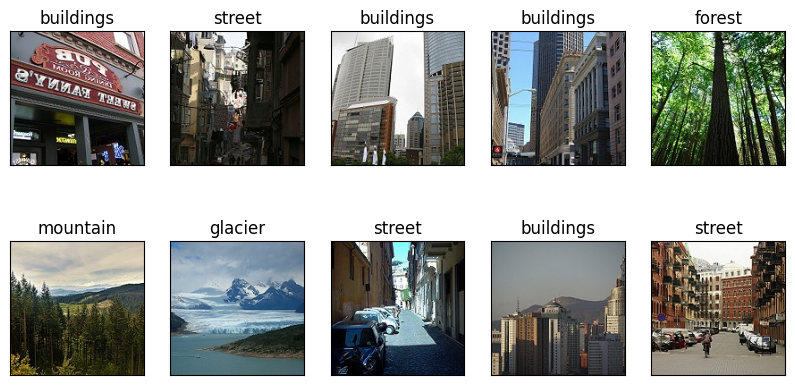

In [ ]:
classes = data_train.classes

data_iter = iter(train_dl)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

n = 10
fig = plt.figure(figsize=(n, 5))

for idx in np.arange(n):
    ax = fig.add_subplot(2, int(n/2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(str(classes[labels[idx].item()]),
        color=("black")
    )

plt.show()